# < FIFA 선수 이적료 예측 >

============================================
### <h> 데이터 : FIFA_train.csv / FIFA_test.csv <h>
    - url = 'https://dacon.io/competitions/open/235538/overview/description
    - 현재 메시는 35세인데 데이터 내에서는 31살이기 때문에 데이터를 분석하는 관점의 연도를 2018년으로 가정
============================================

# < 목차 >
Step 1: 데이터 살펴보고 이해하기</br>
    
Step 2: 데이터 정제
- Missing Value check
- Data type check
- Duplicate check</br>

Step 3: 데이터 시각화
- Boxplot
- Pairplot</br>

Step 4: 학습을 위한 데이터 준비
- Dummy Variable</br>

Step 5: Train, Test 데이터 셋 나누기
- Rescaling</br>

Step 6: 학습 및 검증
- RFE
- VIF</br>

Step 7: Residual Analysis of the train data</br>

Step 8: Making Predictions Using the Final Model</br>

Step 9: Model Evaluation</br>
- RMSE Score
    
    
    
    
    
    
    
    
    
# <h> < FIFA 데이터 Coumns 정보 > <h>
- id : 선수 고유의 아이디 </br>
- name : 이름</br>
- age : 나이</br>
- continent : 선수들의 국적이 포함되어 있는 대륙입니다</br>
- contract_until : 선수의 계약기간이 언제까지인지 나타내어 줍니다</br>
- position : 선수가 선호하는 포지션입니다. ex) 공격수, 수비수 등</br>
- prefer_foot : 선수가 선호하는 발입니다. ex) 오른발</br>
- reputation : 선수가 유명한 정도입니다. ex) 높은 수치일 수록 유명한 선수</br>
- stat_overall : 선수의 현재 능력치 입니다.</br>
- stat_potential : 선수가 경험 및 노력을 통해 발전할 수 있는 정도입니다.</br>
- stat_skill_moves : 선수의 개인기 능력치 입니다.</br>
- value : FIFA가 선정한 선수의 이적 시장 가격 (단위 : 유로) 입니다</br>


In [423]:
# 데이터프레임를 위한 모듈 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta

# 시각화를 위한 모듈 import 
pd.options.display.float_format='{:.4f}'.format
plt.rcParams['figure.figsize'] = [8,8]
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1) 
sns.set(color_codes=True)
from matplotlib import rc
plt.rcParams["axes.unicode_minus"] = False
rc("font", family = "Arial Unicode MS")
%matplotlib inline 
get_ipython().run_line_magic("matplotlib","inline")

# gif를 위한 모듈 import 
from matplotlib.animation import FuncAnimation

# 머신러닝을 위한 모듈 import
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.base import TransformerMixin
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from scipy import stats

# Step 1 :  데이터 읽기 및 이해

In [424]:
df_train = pd.read_csv('./FIFA_train.csv')
df_test = pd.read_csv('./FIFA_test.csv')
print('>'*60+"   Train   "+'<'*60)
display(df_train.head())
print('>'*60+"   Test   "+'<'*60)
display(df_test.head())

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>   Train   <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0000,94,94,4.0000,110500000.0000
1,3,De Gea,27,europe,2020,GK,right,4.0000,91,93,1.0000,72000000.0000
2,7,L. Suárez,31,south america,2021,ST,right,5.0000,91,91,3.0000,80000000.0000
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0000,91,91,3.0000,51000000.0000
4,9,J. Oblak,25,europe,2021,GK,right,3.0000,90,93,1.0000,68000000.0000


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>   Test   <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,1,Cristiano Ronaldo,33,europe,2022,ST,right,5.0000,94,94,5.0000
1,2,Neymar Jr,26,south america,2022,ST,right,5.0000,92,93,5.0000
2,4,K. De Bruyne,27,europe,2023,MF,right,4.0000,91,92,4.0000
3,5,E. Hazard,27,europe,2020,ST,right,4.0000,91,91,4.0000
4,6,L. Modrić,32,europe,2020,MF,right,4.0000,91,91,4.0000


In [425]:
print('>'*60+"   Train   "+'<'*60)
display(df_train.info())
print('>'*60+"   Test   "+'<'*60)
display(df_test.info())

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>   Train   <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


None

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>   Test   <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3828 entries, 0 to 3827
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                3828 non-null   int64  
 1   name              3828 non-null   object 
 2   age               3828 non-null   int64  
 3   continent         3828 non-null   object 
 4   contract_until    3828 non-null   object 
 5   position          3828 non-null   object 
 6   prefer_foot       3828 non-null   object 
 7   reputation        3828 non-null   float64
 8   stat_overall      3828 non-null   int64  
 9   stat_potential    3828 non-null   int64  
 10  stat_skill_moves  3828 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 329.1+ KB


None

In [426]:
print('>'*60+"   Train   "+'<'*60)
display(df_train.describe())
print('>'*60+"   Test   "+'<'*60)
display(df_test.describe())

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>   Train   <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.0000,8932.0000,8932.0000,8932.0000,8932.0000,8932.0000,8932.0000
mean,7966.7758,25.2091,1.1309,67.0911,71.9972,2.4017,2778673.3094
std,4844.4285,4.6355,0.4238,6.8549,5.9881,0.7760,5840981.5211
min,0.0000,16.0000,1.0000,47.0000,48.0000,1.0000,10000.0000
25%,3751.7500,21.0000,1.0000,63.0000,68.0000,2.0000,375000.0000
50%,7696.5000,25.0000,1.0000,67.0000,72.0000,2.0000,825000.0000
75%,12082.2500,28.0000,1.0000,72.0000,76.0000,3.0000,2600000.0000
max,16948.0000,40.0000,5.0000,94.0000,94.0000,5.0000,110500000.0000


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>   Test   <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


,id,age,reputation,stat_overall,stat_potential,stat_skill_moves
count,3828.0000,3828.0000,3828.0000,3828.0000,3828.0000,3828.0000
mean,7846.2581,25.2978,1.1439,67.3370,72.1076,2.4148
std,4870.3394,4.6282,0.4485,6.9088,6.1334,0.7812
min,1.0000,16.0000,1.0000,47.0000,52.0000,1.0000
25%,3466.2500,22.0000,1.0000,63.0000,68.0000,2.0000
50%,7643.5000,25.0000,1.0000,67.0000,72.0000,2.0000
75%,11967.0000,29.0000,1.0000,72.0000,76.0000,3.0000
max,16943.0000,42.0000,5.0000,94.0000,95.0000,5.0000


outlir max : 110500000.0 => 1,100억 유로


(8932, 12)

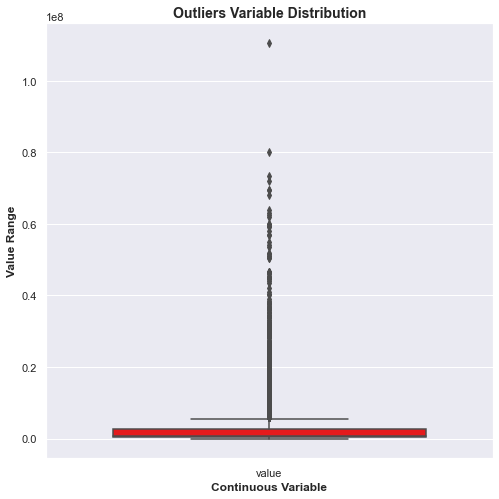

In [427]:
# outlier max값 : 1,100억 유로

sns.set(color_codes=True)

outliers = ['value']
plt.rcParams['figure.figsize'] = [8,8]
sns.boxplot(data=df_train[outliers], orient="v", palette="Set1" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Value Range", fontweight = 'bold')
plt.xlabel("Continuous Variable", fontweight = 'bold')
print(f"outlir max : {df_train[outliers].max()[0]} => 1,100억 유로")
df_train.shape

## 인사이트 :
- outlier들을 이상치라고 할 수 있지만. 제거하지 않고 스케일링 사용

# Step 2 : 데이터 정제

In [428]:
df_train.dtypes

id                  int64  
name                object 
age                 int64  
continent           object 
contract_until      object 
position            object 
prefer_foot         object 
reputation          float64
stat_overall        int64  
stat_potential      int64  
stat_skill_moves    float64
value               float64
dtype: object

In [429]:
# 중복 항목 확인

df_train.loc[df_train.duplicated()]

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value


In [430]:
# id는 drop해도 괜찮음
# name은 drop해도 괜찮음

df_train = df_train.drop(['id','name'],axis=1)
df_train.head()

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,31,south america,2021,ST,left,5.0000,94,94,4.0000,110500000.0000
1,27,europe,2020,GK,right,4.0000,91,93,1.0000,72000000.0000
2,31,south america,2021,ST,right,5.0000,91,91,3.0000,80000000.0000
3,32,europe,2020,DF,right,4.0000,91,91,3.0000,51000000.0000
4,25,europe,2021,GK,right,3.0000,90,93,1.0000,68000000.0000


In [353]:
# 계약기간 만료(contract_until)을 년으로 보기위해서 새로운 column 생성
df_train['contract_year'] = df_train['contract_until'].apply(lambda x: x[-4:])
df_train['contract_year'].value_counts()

2019    2899
2021    2308
2020    2051
2022    761 
2023    506 
2018    391 
2024    12  
2025    3   
2026    1   
Name: contract_year, dtype: int64

In [354]:
# 숫자 및 범주형 변수 - 열 분리

cat_col = df_train.select_dtypes(include=['object']).columns
num_col = df_train.select_dtypes(exclude=['object']).columns
df_cat = df_train[cat_col]
df_num = df_train[num_col]

# step 3 : 데이터 시각화
- 여기서 일부 예측 변수가 결과 변수 가격과 직접적으로 강한 연관성을 가지고 있는지 식별

In [355]:
df_train.columns

Index(['age', 'continent', 'contract_until', 'position', 'prefer_foot',
       'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves',
       'value', 'contract_year'],
      dtype='object')

Text(0, 0.5, 'Count')

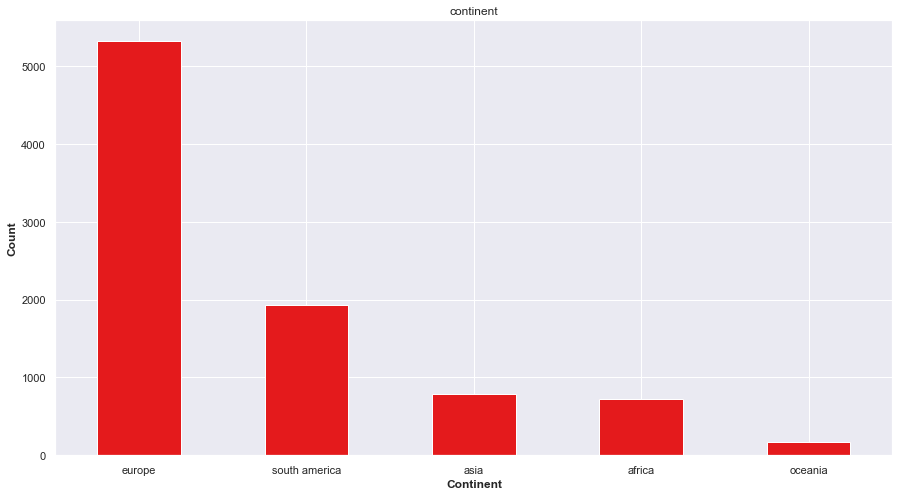

In [356]:
# 대륙별 빈도수 시각화

plt.rcParams['figure.figsize'] = [15,8]
ax=df_train['continent'].value_counts().plot(kind='bar',stacked=True, colormap = 'Set1')
ax.title.set_text('continent')
plt.xlabel("Continent",fontweight = 'bold')
plt.xticks(rotation=0)
plt.ylabel("Count",fontweight = 'bold')

## 인사이트:
- 국적이 유럽인 사람들이 많은 반면에 오세아니아인 사람은 현저히 낮음

<AxesSubplot:title={'center':'Value Distribution Plot'}, xlabel='value', ylabel='Density'>

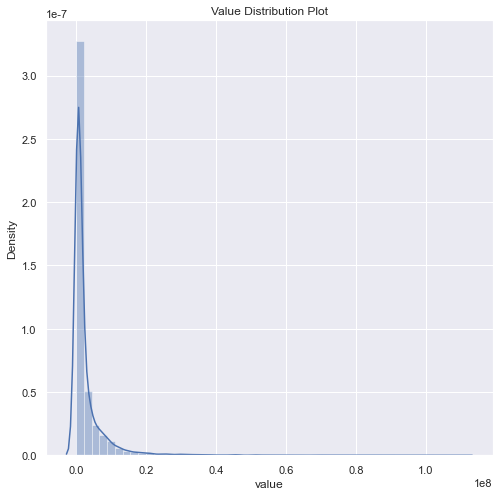

In [357]:
# 예측값의 분포를 보기 위해 시각화

plt.figure(figsize=(8,8))

plt.title('Value Distribution Plot')
sns.distplot(df_train['value'])

## 인사이트 :
- 이적료가 대부분 비슷하지만 특정값들이 조금씩 나오는 것을 알 수 있음

## 숫자형 변수 시각화

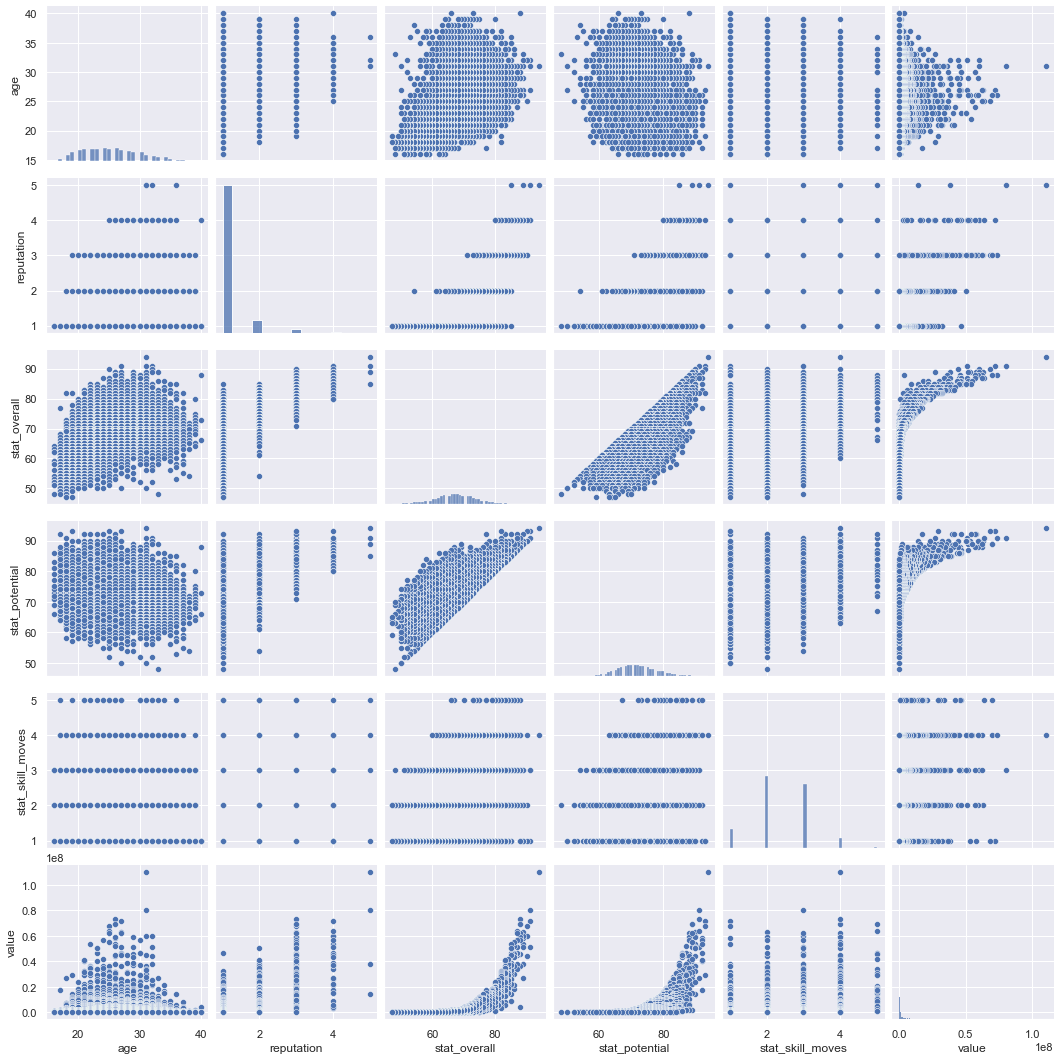

In [358]:
ax = sns.pairplot(df_train[num_col])

In [359]:
### stat_overall >85 , stat_potential의 >90 변수 생성
df_train['stat_overall>85'] = np.where(df_train['stat_overall']>85,1,0)
df_train['stat_potential>90'] = np.where(df_train['stat_potential']>90,1,0)

## 인사이트:
- 선수의 현재 능력치(stat_overall)은 약 85이후로 상당한 양의 상관관계가 나타남
- 선수의 잠재성(stat_potential)은 약 90이후로 상당한 양의 상관관계가 나타남

## 범주형 변수들 시각화 :
- boxplot으로 시각화

In [360]:
cat_col

Index(['continent', 'contract_until', 'position', 'prefer_foot',
       'contract_year'],
      dtype='object')

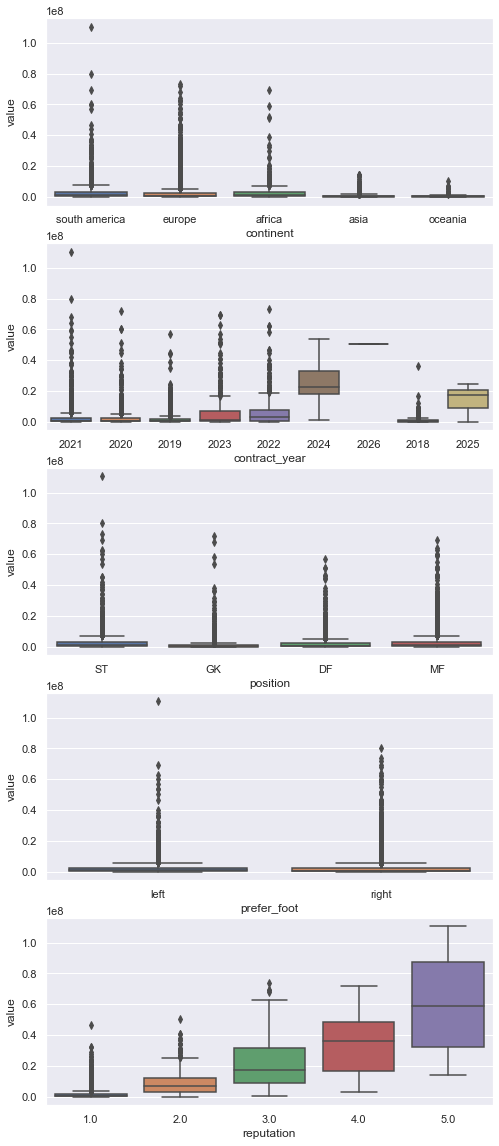

In [361]:
plt.figure(figsize=(8, 20))
plt.subplot(5,1,1)
sns.boxplot(x = 'continent', y = 'value', data = df_train)
plt.subplot(5,1,2)
sns.boxplot(x = 'contract_year', y = 'value', data = df_train)
plt.subplot(5,1,3)
sns.boxplot(x = 'position', y = 'value', data = df_train)
plt.subplot(5,1,4)
sns.boxplot(x = 'prefer_foot', y = 'value', data = df_train)
plt.subplot(5,1,5)
sns.boxplot(x = 'reputation', y = 'value', data = df_train)

plt.show()

## 인사이트 : 
- 선수의 유명한 정도(reputation)와 value는 양의 상관관계가 있을것으로 중요한 변수임을 예상

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'europe'),
  Text(1, 0, 'south america'),
  Text(2, 0, 'asia'),
  Text(3, 0, 'africa'),
  Text(4, 0, 'oceania')])

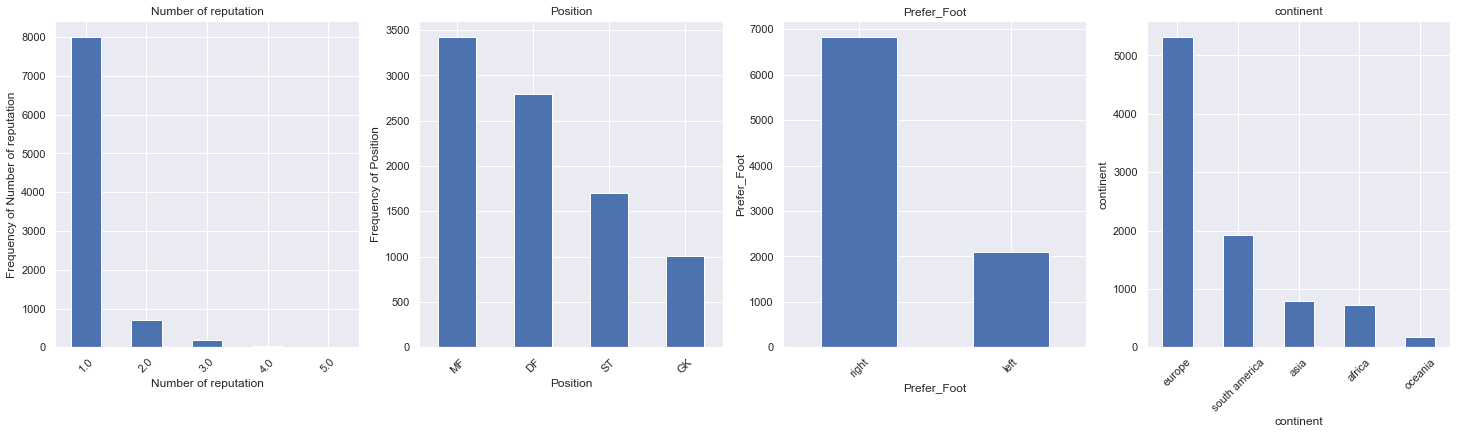

In [362]:
# Reputation, Position, Prefer_Foot, continent


plt.figure(figsize=(25, 6))

plt.subplot(1,4,1)
plt1 = df_train['reputation'].value_counts().plot(kind='bar')
plt.title('Number of reputation')
plt1.set(xlabel = 'Number of reputation', ylabel='Frequency of Number of reputation')
plt.xticks(rotation=45)

plt.subplot(1,4,2)
plt1 = df_train['position'].value_counts().plot(kind='bar')
plt.title('Position')
plt1.set(xlabel = 'Position', ylabel='Frequency of Position')
plt.xticks(rotation=45)

plt.subplot(1,4,3)
plt1 = df_train['prefer_foot'].value_counts().plot(kind='bar')
plt.title('Prefer_Foot')
plt1.set(xlabel = 'Prefer_Foot', ylabel='Prefer_Foot')
plt.xticks(rotation=45)

plt.subplot(1,4,4)
plt1 = df_train['continent'].value_counts().plot(kind='bar')
plt.title('continent')
plt1.set(xlabel = 'continent', ylabel='continent')
plt.xticks(rotation=45)

## 인사이트 :
- 선수들의 유명한 정도는 대부분이 1인것을 확인
- 오른발잡이가 상당수 차지
- 상당수가 유럽국적인 것을 확인

## hue는 prefer_foot으로 주면서 포지션과 value의 관계 비교

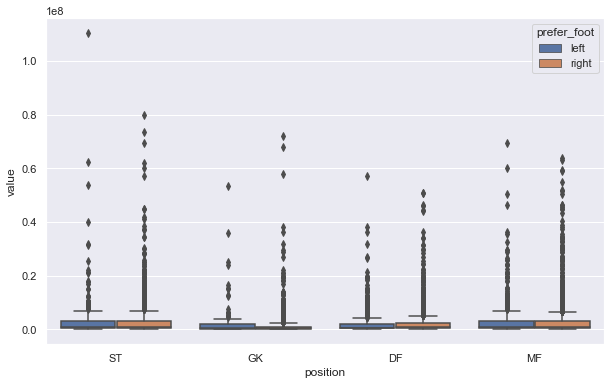

In [363]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'position', y = 'value', hue = 'prefer_foot', data = df_train)
plt.show()

## hue는 position으로 reputation(유명한 정도)와 value를 비교

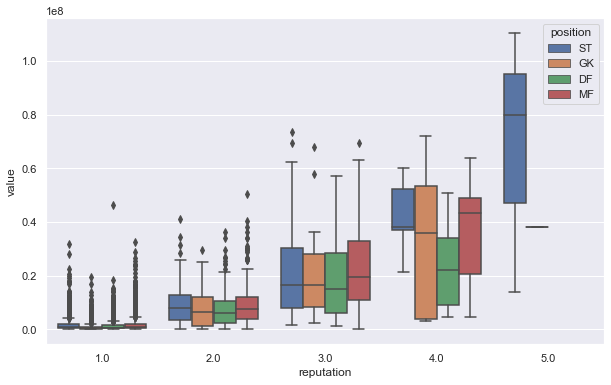

In [364]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'reputation', y = 'value', hue = 'position', data = df_train)
plt.show()

## 인사이트 :
- 유명한 정도가 5인 선수들의 상당 수가 Striker임을 알 수 있고 이적료 또한 비싼것을 알 수 있음

<Figure size 1440x432 with 0 Axes>

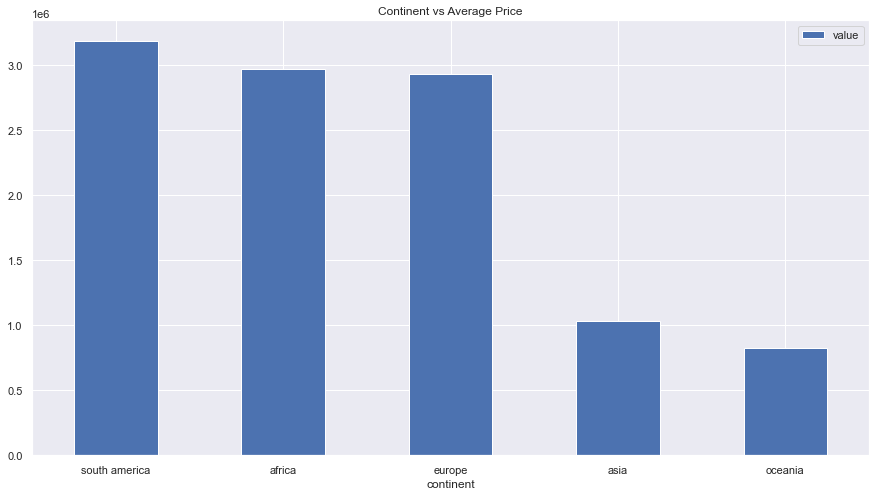

In [365]:
# 대륙별 이적료 평균값

plt.figure(figsize=(20, 6))

df_trainx = pd.DataFrame(df_train.groupby(['continent'])['value'].mean().sort_values(ascending = False))
df_trainx.plot.bar()
plt.title('Continent vs Average Price')
plt.xticks(rotation=0)
plt.show()

## 인사이트 :
- europe에 사람이 많았음에도 불구하고 value의 평균은 south america, africa, europe이 비슷함

<Figure size 1440x432 with 0 Axes>

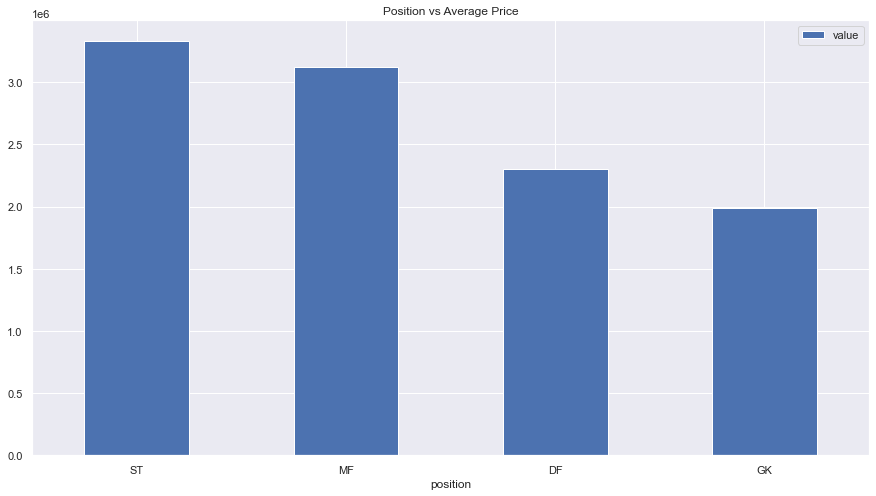

In [366]:
# 포지션 별 이적료 평균값

plt.figure(figsize=(20, 6))

df_trainx = pd.DataFrame(df_train.groupby(['position'])['value'].mean().sort_values(ascending = False))
df_trainx.plot.bar()
plt.title('Position vs Average Price')
plt.xticks(rotation=0)
plt.show()

## 인사이트 :
- striker의 value_counts()의 값은 3번째였지만, value의 평균은 제일 높은것으로 보아 striker들의 이적료가 높을것으로 확인

2019    2899
2021    2308
2020    2051
2022    761 
2023    506 
2018    391 
2024    12  
2025    3   
2026    1   
Name: contract_year, dtype: int64


<Figure size 1440x432 with 0 Axes>

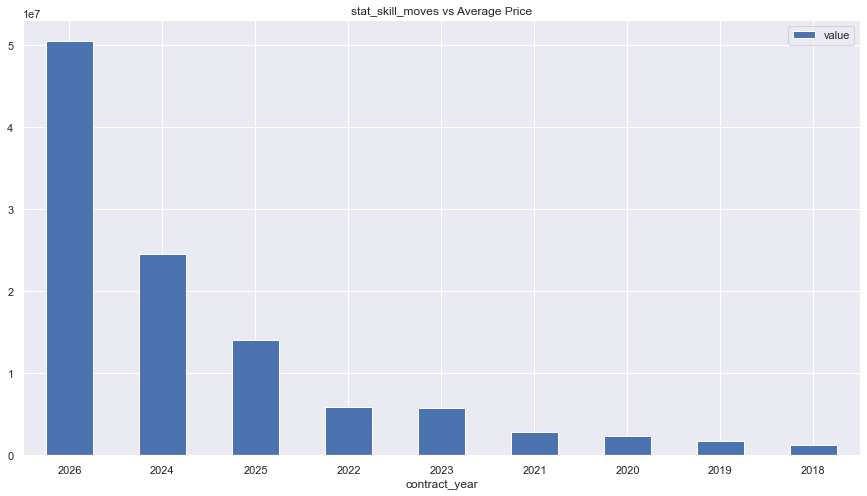

In [367]:
# 계약 만료 기간 별 이적료 평균값

plt.figure(figsize=(20, 6))

print(df_train['contract_year'].value_counts())
df_trainx = pd.DataFrame(df_train.groupby(['contract_year'])['value'].mean().sort_values(ascending = False))
df_trainx.plot.bar()
plt.title('stat_skill_moves vs Average Price')
plt.xticks(rotation=0)
plt.show()

In [368]:
print(">"*50, '2026',"<"*50)
display(df_train[df_train['contract_until'] == '2026'])
print(">"*50, '2025',"<"*50)        
display(df_train[df_train['contract_until'] == '2025'])
print(">"*50, '2024',"<"*50)        
display(df_train[df_train['contract_until'] == '2024'])

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 2026 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,contract_year,stat_overall>85,stat_potential>90
48,23,europe,2026,MF,left,3.0000,85,90,3.0000,50500000.0000,2026,0,0


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 2025 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,contract_year,stat_overall>85,stat_potential>90
202,24,europe,2025,ST,right,2.0000,81,87,4.0000,24500000.0000,2025,0,0
672,17,south america,2025,ST,right,1.0000,77,92,5.0000,17500000.0000,2025,0,1
8496,18,europe,2025,DF,left,1.0000,55,73,2.0000,160000.0000,2025,0,0


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 2024 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,contract_year,stat_overall>85,stat_potential>90
9,26,europe,2024,GK,left,4.0000,89,90,1.0000,53500000.0000,2024,1,0
47,25,south america,2024,GK,right,3.0000,85,90,1.0000,36500000.0000,2024,0,0
66,22,south america,2024,DF,right,2.0000,84,88,2.0000,34000000.0000,2024,0,0
141,21,south america,2024,MF,right,1.0000,82,90,4.0000,32500000.0000,2024,0,0
145,21,europe,2024,MF,right,1.0000,82,86,4.0000,29000000.0000,2024,0,0
203,23,south america,2024,MF,right,1.0000,81,87,4.0000,24500000.0000,2024,0,0
253,22,europe,2024,DF,right,1.0000,80,88,3.0000,18500000.0000,2024,0,0
257,21,europe,2024,MF,left,1.0000,80,87,3.0000,21000000.0000,2024,0,0
259,21,africa,2024,MF,right,1.0000,80,85,3.0000,17000000.0000,2024,0,0
303,25,europe,2024,MF,right,2.0000,80,83,4.0000,18500000.0000,2024,0,0


## 인사이트 :
- 상위 3개는 데이터가 적어서 높게 나온것일수도 있지만, 데이터를 확인해보면 데이터가 적음에도 대부분 상위권인 것을 알 수 있음

<Figure size 1440x432 with 0 Axes>

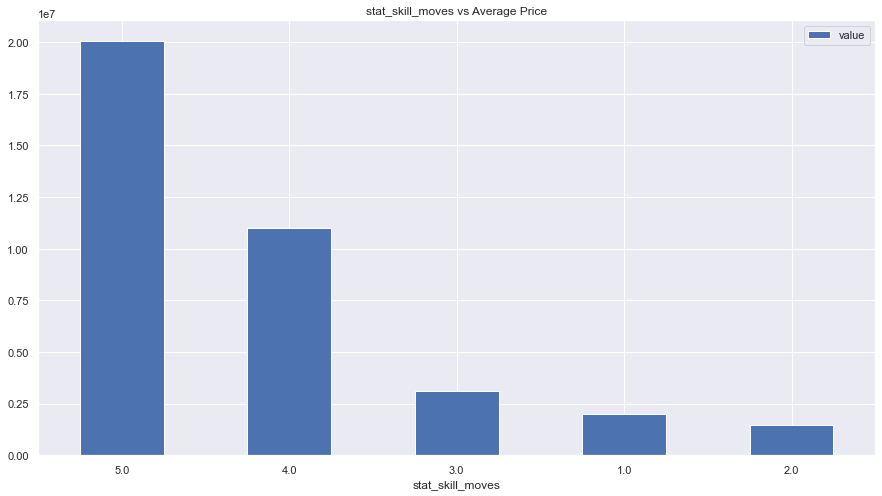

In [369]:
# 개인기 능력치 별 이적료의 평균

plt.figure(figsize=(20, 6))

df_trainx = pd.DataFrame(df_train.groupby(['stat_skill_moves'])['value'].mean().sort_values(ascending = False))
df_trainx.plot.bar()
plt.title('stat_skill_moves vs Average Price')
plt.xticks(rotation=0)
plt.show()

## 인사이트 :
- 개인기 능력치의 평균이 5와 4일때 value값에 영향을 많이줌

<Figure size 1440x432 with 0 Axes>

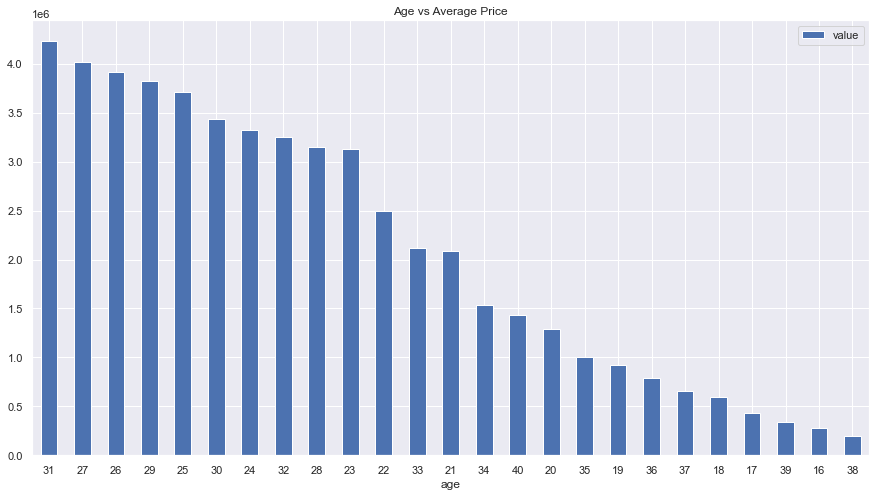

In [370]:
# 나이별 이적료의 평균값

plt.figure(figsize=(20, 6))

df_trainx = pd.DataFrame(df_train.groupby(['age'])['value'].mean().sort_values(ascending = False))
df_trainx.plot.bar()
plt.title('Age vs Average Price')
plt.xticks(rotation=0)
plt.show()

## 인사이트 : 
- 상위 9개가 23~32내에 있는 것으로 보아 age별 value의 평균을 3분류로 나눠서 생성한 변수는 이적료와 상관관계가 있을것으로 예상

In [371]:
# 나이의 평균을 구간을 나눠서 
# 0 => 50000,1600000
# 1 => 1600000,2700000
# 2 => 2700000,4500000


df_train['value'] = df_train['value'].astype('int')
df_train_temp = df_train.copy()
t = df_train_temp.groupby(['age'])['value'].mean()
df_train_temp = df_train_temp.merge(t.reset_index(), how='left',on='age')
df_train_temp
bins = [50000,1600000,2700000,4500000]
label =[0,1,2]
df_train['age_Category'] = pd.cut(df_train_temp['value_y'],bins,right=False,labels=label)
df_train.head()

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,contract_year,stat_overall>85,stat_potential>90,age_Category
0,31,south america,2021,ST,left,5.0000,94,94,4.0000,110500000,2021,1,1,2
1,27,europe,2020,GK,right,4.0000,91,93,1.0000,72000000,2020,1,1,2
2,31,south america,2021,ST,right,5.0000,91,91,3.0000,80000000,2021,1,1,2
3,32,europe,2020,DF,right,4.0000,91,91,3.0000,51000000,2020,1,1,2
4,25,europe,2021,GK,right,3.0000,90,93,1.0000,68000000,2021,1,1,2


In [372]:
# reputation = 4 인 선수 랜던 200명의 값
# 1.0    8014
# 2.0     706
# 3.0     177
# 4.0      31
# 5.0       4

In [373]:
from sklearn.preprocessing import MinMaxScaler
import os
from PIL import Image
from IPython.display import Image as Img
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from matplotlib import font_manager, rc
import sys
import imageio
from PIL import Image

In [374]:
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

MovieWriter ffmpeg unavailable; using Pillow instead.


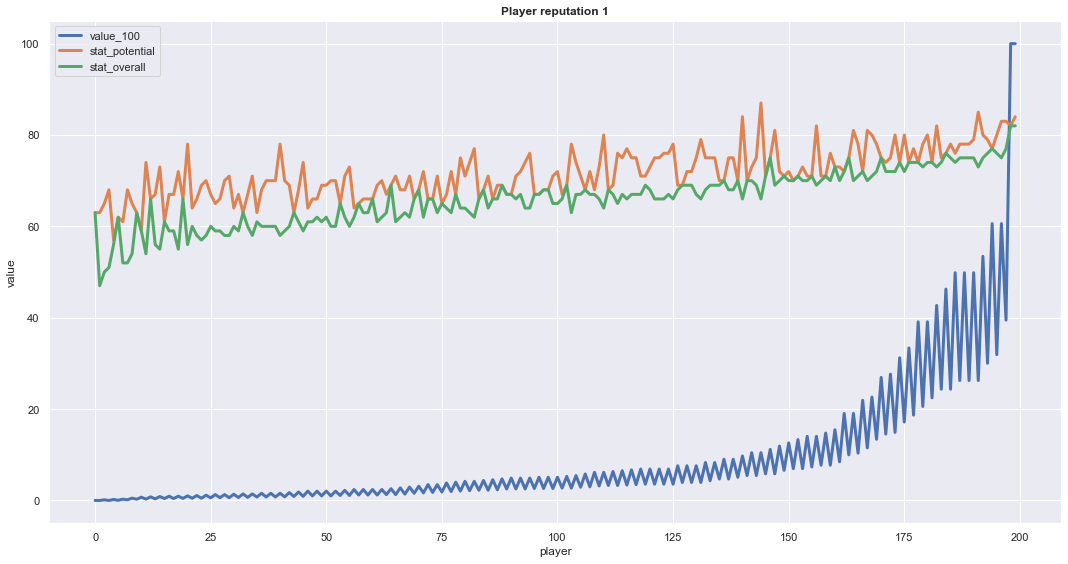

In [375]:
# retation == 1
tmp_data = df_train[['value','reputation','stat_potential','stat_overall']]
tmp_data = tmp_data[tmp_data['reputation']==1]
tmp_data = tmp_data.sample(200)
tmp_data = tmp_data.sort_values(by = ['value','stat_potential','stat_overall'], ascending=True)

scaler = MinMaxScaler()
numeric_data = tmp_data['value'].values
tmp = numeric_data.reshape(-1,2)
tmp_fit = scaler.fit(tmp)
tmp_trans = scaler.transform(tmp)
tmp_re=tmp_trans.reshape(-1,)
tmp_data['value_100'] = tmp_re*100


data1 =  pd.to_numeric(tmp_data['value_100'], downcast='float')
data2 =  pd.to_numeric(tmp_data['stat_potential'], downcast='float')
data3 =  pd.to_numeric(tmp_data['stat_overall'], downcast='float')
#data4 =  pd.to_numeric(tmp['stat_overall'],  downcast='float')


def animate(i):
    x = np.linspace(0,i,i+1)
    y1 = data1[:i+1]
    y2 = data2[:i+1]
    y3 = data3[:i+1]
    #y4 = data4[:i+1] 

    plt.cla()
    plt.plot(x, y1, label='value_100', lw=3)
    plt.plot(x, y2, label='stat_potential', lw=3)
    plt.plot(x, y3, label='stat_overall', lw=3)
    #plt.plot(x, y4, label='stat_overall', lw=3)

    plt.title('Player reputation 1', fontweight='bold')
    plt.ylabel('value')
    plt.xlabel('player')
    plt.legend(loc='upper left')
    plt.tight_layout()

ani = FuncAnimation(plt.gcf(), animate, frames=200, interval=1)
ani.save('./reputation_1.gif', fps=20)



Img(url='reputation_1.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


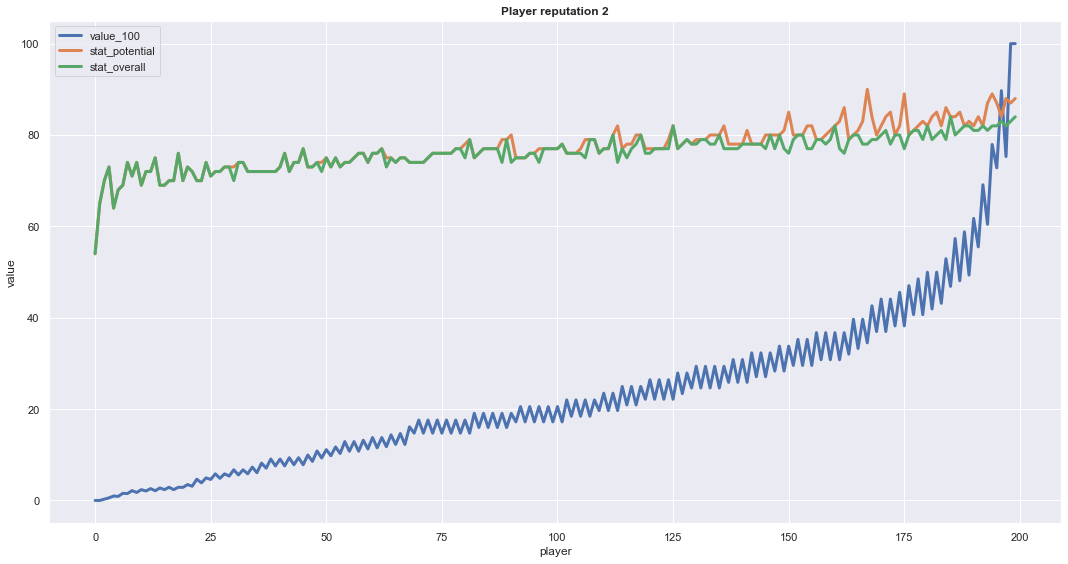

In [376]:
# reputatiion == 2

tmp_data = df_train[['value','reputation','stat_potential','stat_overall']]
tmp_data = tmp_data[tmp_data['reputation']==2]
tmp_data = tmp_data.sample(200)
tmp_data = tmp_data.sort_values(by = ['value','stat_potential','stat_overall'], ascending=True)

scaler = MinMaxScaler()
numeric_data = tmp_data['value'].values
tmp = numeric_data.reshape(-1,2)
tmp_fit = scaler.fit(tmp)
tmp_trans = scaler.transform(tmp)
tmp_re=tmp_trans.reshape(-1,)
tmp_data['value_100'] = tmp_re*100


data1 =  pd.to_numeric(tmp_data['value_100'], downcast='float')
data2 =  pd.to_numeric(tmp_data['stat_potential'], downcast='float')
data3 =  pd.to_numeric(tmp_data['stat_overall'], downcast='float')
#data4 =  pd.to_numeric(tmp['stat_overall'],  downcast='float')


def animate(i):
    x = np.linspace(0,i,i+1)
    y1 = data1[:i+1]
    y2 = data2[:i+1]
    y3 = data3[:i+1]
    #y4 = data4[:i+1] 

    plt.cla()
    plt.plot(x, y1, label='value_100', lw=3)
    plt.plot(x, y2, label='stat_potential', lw=3)
    plt.plot(x, y3, label='stat_overall', lw=3)
    #plt.plot(x, y4, label='stat_overall', lw=3)

    plt.title('Player reputation 2', fontweight='bold')
    plt.ylabel('value')
    plt.xlabel('player')
    plt.legend(loc='upper left')
    plt.tight_layout()

ani = FuncAnimation(plt.gcf(), animate, frames=200, interval=1)
ani.save('./reputation_2.gif', fps=20)


Img(url='reputation_2.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


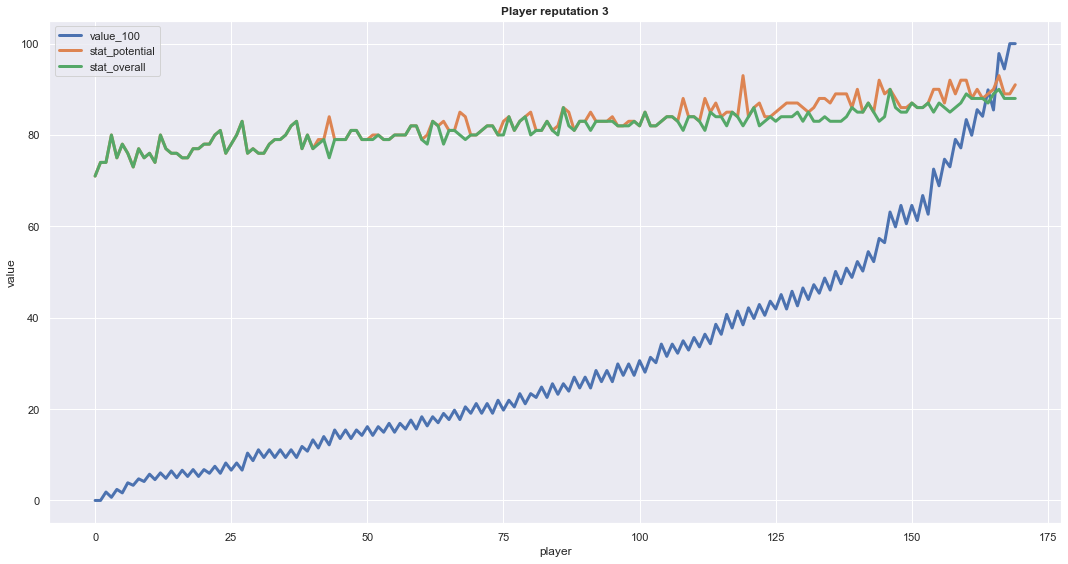

In [377]:
# reputation == 3
tmp_data = df_train[['value','reputation','stat_potential','stat_overall']]
tmp_data = tmp_data[tmp_data['reputation']==3]
tmp_data = tmp_data.sample(170)
tmp_data = tmp_data.sort_values(by = ['value','stat_potential','stat_overall'], ascending=True)

scaler = MinMaxScaler()
numeric_data = tmp_data['value'].values
tmp = numeric_data.reshape(-1,2)
tmp_fit = scaler.fit(tmp)
tmp_trans = scaler.transform(tmp)
tmp_re=tmp_trans.reshape(-1,)
tmp_data['value_100'] = tmp_re*100


data1 =  pd.to_numeric(tmp_data['value_100'], downcast='float')
data2 =  pd.to_numeric(tmp_data['stat_potential'], downcast='float')
data3 =  pd.to_numeric(tmp_data['stat_overall'], downcast='float')
#data4 =  pd.to_numeric(tmp['stat_overall'],  downcast='float')


def animate(i):
    x = np.linspace(0,i,i+1)
    y1 = data1[:i+1]
    y2 = data2[:i+1]
    y3 = data3[:i+1]
    #y4 = data4[:i+1] 

    plt.cla()
    plt.plot(x, y1, label='value_100', lw=3)
    plt.plot(x, y2, label='stat_potential', lw=3)
    plt.plot(x, y3, label='stat_overall', lw=3)
    #plt.plot(x, y4, label='stat_overall', lw=3)

    plt.title('Player reputation 3', fontweight='bold')
    plt.ylabel('value')
    plt.xlabel('player')
    plt.legend(loc='upper left')
    plt.tight_layout()

ani = FuncAnimation(plt.gcf(), animate, frames=170, interval=1)
ani.save('./reputation_3.gif', fps=17)


Img(url='reputation_3.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


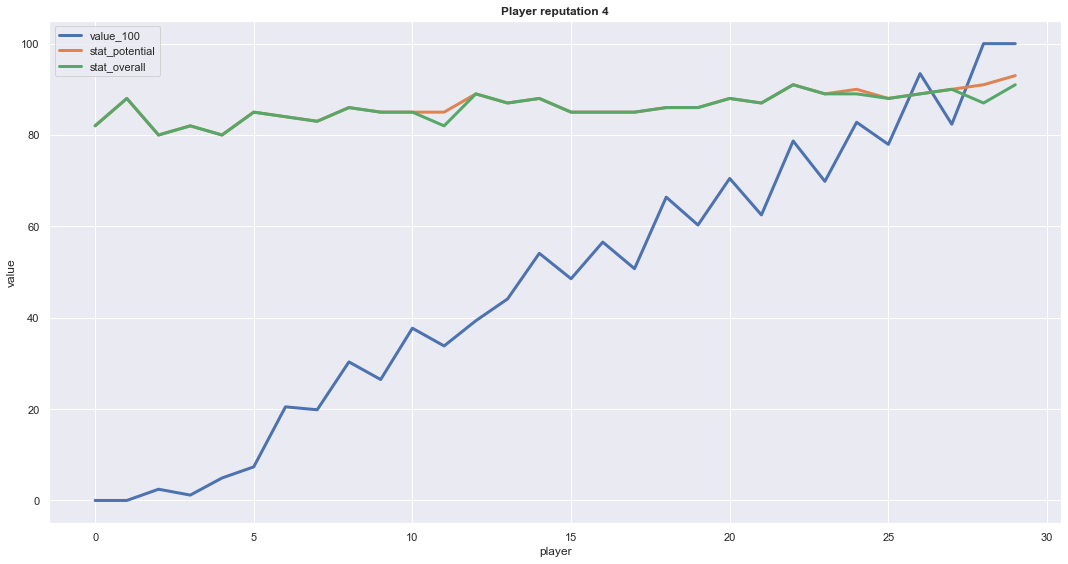

In [378]:
# reputation == 4
tmp_data = df_train[['value','reputation','stat_potential','stat_overall']]
tmp_data = tmp_data[tmp_data['reputation']==4]
tmp_data = tmp_data.sample(30)
tmp_data = tmp_data.sort_values(by = ['value','stat_potential','stat_overall'], ascending=True)

scaler = MinMaxScaler()
numeric_data = tmp_data['value'].values
tmp = numeric_data.reshape(-1,2)
tmp_fit = scaler.fit(tmp)
tmp_trans = scaler.transform(tmp)
tmp_re=tmp_trans.reshape(-1,)
tmp_data['value_100'] = tmp_re*100


data1 =  pd.to_numeric(tmp_data['value_100'], downcast='float')
data2 =  pd.to_numeric(tmp_data['stat_potential'], downcast='float')
data3 =  pd.to_numeric(tmp_data['stat_overall'], downcast='float')
#data4 =  pd.to_numeric(tmp['stat_overall'],  downcast='float')


def animate(i):
    x = np.linspace(0,i,i+1)
    y1 = data1[:i+1]
    y2 = data2[:i+1]
    y3 = data3[:i+1]
    #y4 = data4[:i+1] 

    plt.cla()
    plt.plot(x, y1, label='value_100', lw=3)
    plt.plot(x, y2, label='stat_potential', lw=3)
    plt.plot(x, y3, label='stat_overall', lw=3)
    #plt.plot(x, y4, label='stat_overall', lw=3)

    plt.title('Player reputation 4', fontweight='bold')
    plt.ylabel('value')
    plt.xlabel('player')
    plt.legend(loc='upper left')
    plt.tight_layout()

ani = FuncAnimation(plt.gcf(), animate, frames=30 , interval=1)
ani.save('./reputation_4.gif', fps=3)


Img(url='reputation_4.gif')

## 인사이트 :
- reputation(유명한 정도)가 1~4로 높아질수록 stat_overall(개인능력치)가 stat_potential(잠재성)과 비슷해짐. 
- 즉, reputation의 값이 높은 사람들은 잠재성이 높음

## value 에 영향을 미치는값의 분석


- reputation(0.67, 인기), stat_overall(0.66, 능력치), stat_potential(0.61, 성장가능성)

- value 값은 위 3개의 요소에 가장 많은 영향을 받는다.

- value(이적 시장 가격)와 관계가 높은 것은 'stat_overall', 'reputation', 'stat_potential'

<AxesSubplot:>

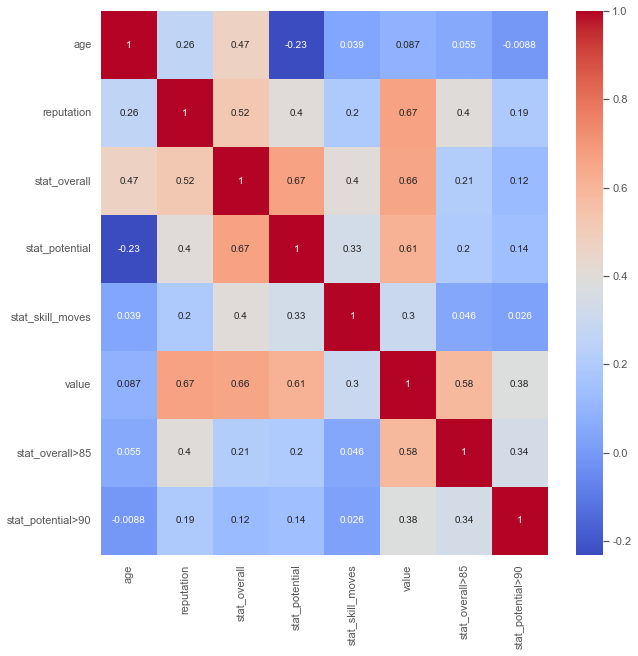

In [379]:
# 상관관계 확인

tmp =df_train.corr()
plt.figure(figsize=(10,10))
plt.style.use('ggplot')
sns.heatmap(tmp, cmap='coolwarm', annot=True)

## 시각화 후 중요 변수들:
- reputation(유명한 정도), stat_overall(현재 능력치), stat_potential(잠재성), stat_skill_moves(개인기 능력치)

# Step 4 : 데이터 준비

In [380]:
from scipy import stats

### 이적료값 스케일링

#### 왜도(Skewness): 분포의 비대칭도
- 정규분포 = 왜도 0
- 왼쪽으로 치우침 = 왜도 > 0
- 오른쪽으로 치우침 = 왜도 < 0

방법1 ) 로그 변환

방법2 ) 루트 변환

방법3 ) boxcox 변환

In [381]:
x_data.head()

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,contract_year,age_Category,log_value,root_value,boxcox_value,stat_overall>85,stat_potential>90
0,31,south america,2021,ST,left,5.0000,0.2350,0.2350,4.0000,110500000,2021,2,18.5205,10511.8980,9.5096,0,0
1,27,europe,2020,GK,right,4.0000,0.2275,0.2325,1.0000,72000000,2020,2,18.0922,8485.2814,9.4145,0,0
2,31,south america,2021,ST,right,5.0000,0.2275,0.2275,3.0000,80000000,2021,2,18.1975,8944.2719,9.4382,0,0
3,32,europe,2020,DF,right,4.0000,0.2275,0.2275,3.0000,51000000,2020,2,17.7473,7141.4284,9.3355,0,0
4,25,europe,2021,GK,right,3.0000,0.2250,0.2325,1.0000,68000000,2021,2,18.0350,8246.2113,9.4016,0,0


<AxesSubplot:title={'center':'Value Distribution Plot'}, xlabel='value', ylabel='Density'>

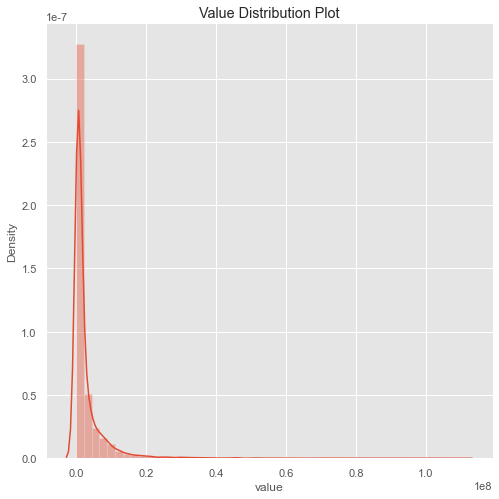

In [382]:
# 이적료의 분포

plt.figure(figsize=(8,8))

plt.title('Value Distribution Plot')
sns.distplot(df_train['value'])

In [383]:
#value 변환
df_train['log_value'] = np.log1p(df_train['value'])
df_train['root_value'] = np.sqrt(df_train['value'])
df_train['boxcox_value'] = pd.Series(stats.boxcox(df_train['value'])[0])

In [384]:
#변환 후 skew 값 확인 (왜도)
# 값이 0에 가까울수록 정규분포의 

print("로그변환      :   ", df_train['log_value'].skew())
print("루트변환      :   ", df_train['root_value'].skew())
print("box-cox변환  :   ", df_train['boxcox_value'].skew())

로그변환      :    0.30879767174080225
루트변환      :    2.3177338710100113
box-cox변환  :    0.009437994228687891


<AxesSubplot:xlabel='boxcox_value', ylabel='Density'>

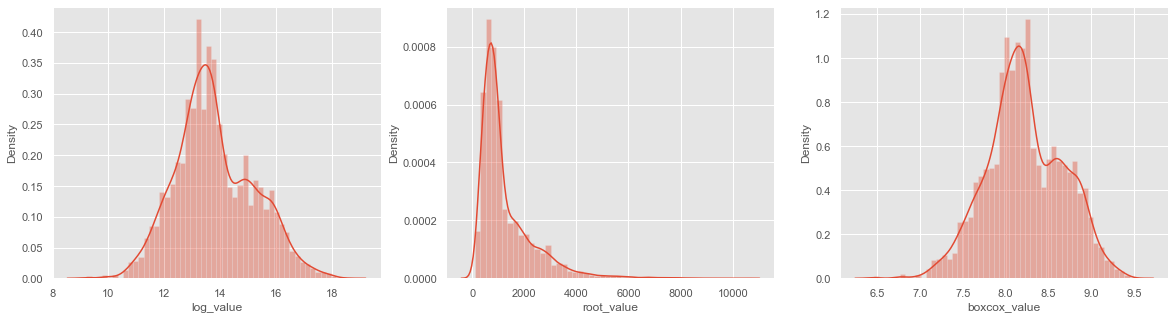

In [385]:
#그래프 확인
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

sns.distplot(df_train['log_value'], ax=ax[0])
sns.distplot(df_train['root_value'], ax=ax[1])
sns.distplot(df_train['boxcox_value'], ax=ax[2])

In [386]:
#평균, 편차, 최소값, 최대값 비교
print("log 변환     >> 평균 : {:.4f} 편차 : {:.4f}  최소값 : {:.4f}  최대값 : {:.4f} ".format(np.mean(df_train['log_value']), np.std(df_train['log_value']), np.min(df_train['log_value']), np.max(df_train['log_value'])))
print("root 변환    >> 평균 : {:.2f} 편차 : {:.2f}  최소값 : {:.2f}  최대값 : {:.2f} ".format(np.mean(df_train['root_value']), np.std(df_train['root_value']), np.min(df_train['root_value']), np.max(df_train['root_value'])))
print("box-cox 변환 >> 평균 : {:.4f} 편차 : {:.4f}  최소값 : {:.4f}  최대값 : {:.4f} ".format(np.mean(df_train['boxcox_value']), np.std(df_train['boxcox_value']), np.min(df_train['boxcox_value']), np.max(df_train['boxcox_value'])))


log 변환     >> 평균 : 13.7939 편차 : 1.4016  최소값 : 9.2104  최대값 : 18.5205 
root 변환    >> 평균 : 1282.28 편차 : 1065.10  최소값 : 100.00  최대값 : 10511.90 
box-cox 변환 >> 평균 : 8.2240 편차 : 0.4469  최소값 : 6.4589  최대값 : 9.5096 


In [387]:
# 루트 변환 값 제외하고 원 value, log변환값, boxcox값으로 y_data값 만들기
y_data = df_train['value'].copy()
y_data_log = df_train['log_value'].copy()
y_data_boxcox = df_train['boxcox_value'].copy()

In [388]:
df_train.head()

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,contract_year,stat_overall>85,stat_potential>90,age_Category,log_value,root_value,boxcox_value
0,31,south america,2021,ST,left,5.0000,94,94,4.0000,110500000,2021,1,1,2,18.5205,10511.8980,9.5096
1,27,europe,2020,GK,right,4.0000,91,93,1.0000,72000000,2020,1,1,2,18.0922,8485.2814,9.4145
2,31,south america,2021,ST,right,5.0000,91,91,3.0000,80000000,2021,1,1,2,18.1975,8944.2719,9.4382
3,32,europe,2020,DF,right,4.0000,91,91,3.0000,51000000,2020,1,1,2,17.7473,7141.4284,9.3355
4,25,europe,2021,GK,right,3.0000,90,93,1.0000,68000000,2021,1,1,2,18.0350,8246.2113,9.4016


In [389]:
#stat_overall, stat_potential 100점 만점 변수를 5점 만점으로 변환
x_data['stat_overall']=x_data['stat_overall']/100*5
x_data['stat_potential']=x_data['stat_potential']/100*5

x_data.head()

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,contract_year,age_Category,log_value,root_value,boxcox_value,stat_overall>85,stat_potential>90
0,31,south america,2021,ST,left,5.0000,0.0117,0.0117,4.0000,110500000,2021,2,18.5205,10511.8980,9.5096,0,0
1,27,europe,2020,GK,right,4.0000,0.0114,0.0116,1.0000,72000000,2020,2,18.0922,8485.2814,9.4145,0,0
2,31,south america,2021,ST,right,5.0000,0.0114,0.0114,3.0000,80000000,2021,2,18.1975,8944.2719,9.4382,0,0
3,32,europe,2020,DF,right,4.0000,0.0114,0.0114,3.0000,51000000,2020,2,17.7473,7141.4284,9.3355,0,0
4,25,europe,2021,GK,right,3.0000,0.0112,0.0116,1.0000,68000000,2021,2,18.0350,8246.2113,9.4016,0,0


### 범주형 변수 더미화 진행

In [390]:
#object변수를 더미변수로 변환
train = pd.get_dummies(x_data.drop(['contract_until','value','log_value','root_value','boxcox_value'],axis=1), drop_first=True)
train.head()

,age,reputation,stat_overall,stat_potential,stat_skill_moves,stat_overall>85,stat_potential>90,continent_asia,continent_europe,continent_oceania,continent_south america,position_GK,position_MF,position_ST,prefer_foot_right,contract_year_2019,contract_year_2020,contract_year_2021,contract_year_2022,contract_year_2023,contract_year_2024,contract_year_2025,contract_year_2026,age_Category_1,age_Category_2
0,31,5.0000,0.0117,0.0117,4.0000,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
1,27,4.0000,0.0114,0.0116,1.0000,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1
2,31,5.0000,0.0114,0.0114,3.0000,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1
3,32,4.0000,0.0114,0.0114,3.0000,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
4,25,3.0000,0.0112,0.0116,1.0000,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1


In [391]:
# #아무작업 하지 않은 age변수에 대한 고민
# # 값 유지
# x_data['age']
# #왼쪽 치우침, 왜도 > 로그 변환
# x_data['age_log'] = np.log1p(x_data['age'])
# #min-max scaling
# x_data['age_minmax'] = (x_data['age']-x_data['age'].min())/(x_data['age'].max()-x_data['age'].min())
# #standard scaling
# x_data['age_std'] = (x_data['age']-x_data['age'].mean())/x_data['age'].std()

In [392]:
# #스케일링 결과 확인
# print("age            >> 평균 : {:.4f} 편차 : {:.4f}  최소값 : {:.4f}  최대값 : {:.4f} ".format(np.mean(x_data['age']), np.std(x_data['age']), np.min(x_data['age']), np.max(x_data['age'])))
# print("age_log        >> 평균 : {:.4f} 편차 : {:.4f}  최소값 : {:.4f}  최대값 : {:.4f} ".format(np.mean(x_data['age_log']), np.std(x_data['age_log']), np.min(x_data['age_log']), np.max(x_data['age_log'])))
# print("age_minmax     >> 평균 : {:.4f} 편차 : {:.4f}  최소값 : {:.4f}  최대값 : {:.4f} ".format(np.mean(x_data['age_minmax']), np.std(x_data['age_minmax']), np.min(x_data['age_minmax']), np.max(x_data['age_minmax'])))
# print("age_std        >> 평균 : {:.4f} 편차 : {:.4f}  최소값 : {:.4f}  최대값 : {:.4f} ".format(np.mean(x_data['age_std']), np.std(x_data['age_std']), np.min(x_data['age_std']), np.max(x_data['age_std'])))

In [393]:
# #X dataset copy
# x_data_basic = x_data.copy()
# x_data_log = x_data.copy()
# x_data_minmax = x_data.copy()
# x_data_std = x_data.copy()

In [394]:
# #불필요 변수 삭제
# x_data_basic.drop(['age_log','age_minmax','age_std'], axis=1)
# x_data_log.drop(['age','age_minmax','age_std'], axis=1)
# x_data_minmax.drop(['age','age_log','age_std'], axis=1)
# x_data_std.drop(['age','age_log','age_minmax'], axis=1)

# Step 5 : train, test 셋 나누기

In [417]:
#X데이터 선정
X = train
y_basicvalue = x_data['value']
y_logvalue = x_data['log_value']
y_rootvalue = x_data['root_value']
y_boxcoxvalue = x_data['boxcox_value']


print(X.shape, y_basicvalue.shape, y_logvalue.shape, y_rootvalue.shape, y_boxcox_value.shape)

(8929, 25) (8929,) (8929,) (8929,) (8929,)


In [421]:
from sklearn.model_selection import train_test_split

X_train_basic, X_test_basic, y_train_basic, y_test_basic = train_test_split(
    X, y_basicvalue, random_state=100
)

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X, y_logvalue, random_state=100
)

X_train_root, X_test_root, y_train_root, y_test_root = train_test_split(
    X, y_rootvalue, random_state=100
)

X_train_boxcox, X_test_boxcox, y_train_boxcox, y_test_boxcox = train_test_split(
    X, y_boxcoxvalue, random_state=100
)

In [422]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_basic, y_train_basic)
lr.score(X_test_basic, y_test_basic)

0.6661545897347345

# Step 6: 학습 및 검증

## linear regression

In [91]:
# x_name = []
# y_name = []
# tr_rmse = []
# test_rmse = []
# train_score=[]
# test_score = []

# x_dataset = [x_data_basic, x_data_log, x_data_minmax, x_data_std]
# y_dataset = [y_data, y_data_log, y_data_boxcox]

# x_dataset_name = ["x_data_basic", "x_data_log", "x_data_minmax", "x_data_std"]
# y_dataset_name = ["y_data", "y_data_log", "y_data_boxcox"]

In [92]:
a#데이터셋별로 모델링 진행

y = [y_value, y_logvalue, y_rootvalue, y_boxcox_value]

y_data = []
r2_score = []
rmse = []
mae = []


for i in range()



for i, a in enumerate(x_dataset):
    for j, b in enumerate(y_dataset):
        X_train, X_test, y_train, y_test = train_test_split(a, b, test_size=0.3, random_state=9)

        reg = LinearRegression()
        reg.fit(X_train, y_train)

        pred_tr = reg.predict(X_train)
        pred_test = reg.predict(X_test)
        rmse_tr = (np.sqrt(mean_squared_error(y_train, pred_tr)))
        rmse_test = (np.sqrt(mean_squared_error(y_test, pred_test)))

        x_name.append(x_dataset_name[i])
        y_name.append(y_dataset_name[j])
        tr_rmse.append(rmse_tr)
        test_rmse.append(rmse_test)
        train_score.append(reg.score(X_train,y_train))
        test_score.append(reg.score(X_test, y_test))

In [93]:
#결과를 데이터 프레임으로 정리
df_linear = pd.DataFrame({'X_data' : x_name,
                  'y_data' : y_name,
                  'train_rmse' : tr_rmse,
                  'test_rmse' : test_rmse,
                  'train_score' : train_score,
                  'test_score' : test_score})

In [94]:
#확인
display(df_linear)

,X_data,y_data,train_rmse,test_rmse,train_score,test_score
0,x_data_basic,y_data,3387527.8000,3425816.4283,0.6613,0.6614
1,x_data_basic,y_data_log,0.2243,0.2316,0.9746,0.9723
2,x_data_basic,y_data_boxcox,0.0727,0.0737,0.9738,0.9722
3,x_data_log,y_data,3387527.8000,3425816.4283,0.6613,0.6614
4,x_data_log,y_data_log,0.2243,0.2316,0.9746,0.9723
5,x_data_log,y_data_boxcox,0.0727,0.0737,0.9738,0.9722
6,x_data_minmax,y_data,3387527.8000,3425816.4283,0.6613,0.6614
7,x_data_minmax,y_data_log,0.2243,0.2316,0.9746,0.9723
8,x_data_minmax,y_data_boxcox,0.0727,0.0737,0.9738,0.9722
9,x_data_std,y_data,3387527.8000,3425816.4283,0.6613,0.6614


# Random Forest

In [95]:
#초기화
x_name = []
y_name = []
tr_rmse = []
test_rmse = []
train_score=[]
test_score = []

x_dataset = [x_data_basic, x_data_log, x_data_minmax, x_data_std]
y_dataset = [y_data, y_data_log, y_data_boxcox]

x_dataset_name = ["x_data_basic", "x_data_log", "x_data_minmax", "x_data_std"]
y_dataset_name = ["y_data", "y_data_log", "y_data_boxcox"]

In [96]:
#데이터셋별로 모델링 진행
for i, a in enumerate(x_dataset):
    for j, b in enumerate(y_dataset):
        X_train, X_test, y_train, y_test = train_test_split(a, b, test_size=0.3, random_state=9)

        rfref = RandomForestRegressor()
        rfref.fit(X_train, y_train)

        pred_tr = rfref.predict(X_train)
        pred_test = rfref.predict(X_test)
        rmse_tr = (np.sqrt(mean_squared_error(y_train, pred_tr)))
        rmse_test = (np.sqrt(mean_squared_error(y_test, pred_test)))

        x_name.append(x_dataset_name[i])
        y_name.append(y_dataset_name[j])
        tr_rmse.append(rmse_tr)
        test_rmse.append(rmse_test)
        train_score.append(rfref.score(X_train,y_train))
        test_score.append(rfref.score(X_test, y_test))

In [97]:
#결과를 데이터 프레임으로 정리
df_randomforest = pd.DataFrame({'X_data' : x_name,
                  'y_data' : y_name,
                  'train_rmse' : tr_rmse,
                  'test_rmse' : test_rmse,
                  'train_score' : train_score,
                  'test_score' : test_score})

In [98]:
display(df_randomforest)

,X_data,y_data,train_rmse,test_rmse,train_score,test_score
0,x_data_basic,y_data,440000.7879,896418.0720,0.9943,0.9768
1,x_data_basic,y_data_log,0.0379,0.0949,0.9993,0.9954
2,x_data_basic,y_data_boxcox,0.0127,0.0311,0.9992,0.9951
3,x_data_log,y_data,395937.6153,877255.2414,0.9954,0.9778
4,x_data_log,y_data_log,0.0373,0.0934,0.9993,0.9955
5,x_data_log,y_data_boxcox,0.0129,0.0316,0.9992,0.9949
6,x_data_minmax,y_data,404099.7862,823061.6755,0.9952,0.9805
7,x_data_minmax,y_data_log,0.0374,0.0959,0.9993,0.9953
8,x_data_minmax,y_data_boxcox,0.0126,0.0307,0.9992,0.9952
9,x_data_std,y_data,383688.0865,900382.0706,0.9957,0.9766


# Xgboost

In [99]:
#초기화
x_name = []
y_name = []
tr_rmse = []
test_rmse = []
train_score=[]
test_score = []

x_dataset = [x_data_basic, x_data_log, x_data_minmax, x_data_std]
y_dataset = [y_data, y_data_log, y_data_boxcox]

x_dataset_name = ["x_data_basic", "x_data_log", "x_data_minmax", "x_data_std"]
y_dataset_name = ["y_data", "y_data_log", "y_data_boxcox"]

x_data_basic y_data AxesSubplot(0.125,0.125;0.775x0.755)
x_data_basic y_data_log AxesSubplot(0.125,0.125;0.775x0.755)
x_data_basic y_data_boxcox AxesSubplot(0.125,0.125;0.775x0.755)
x_data_log y_data AxesSubplot(0.125,0.125;0.775x0.755)
x_data_log y_data_log AxesSubplot(0.125,0.125;0.775x0.755)
x_data_log y_data_boxcox AxesSubplot(0.125,0.125;0.775x0.755)
x_data_minmax y_data AxesSubplot(0.125,0.125;0.775x0.755)
x_data_minmax y_data_log AxesSubplot(0.125,0.125;0.775x0.755)
x_data_minmax y_data_boxcox AxesSubplot(0.125,0.125;0.775x0.755)
x_data_std y_data AxesSubplot(0.125,0.125;0.775x0.755)
x_data_std y_data_log AxesSubplot(0.125,0.125;0.775x0.755)
x_data_std y_data_boxcox AxesSubplot(0.125,0.125;0.775x0.755)


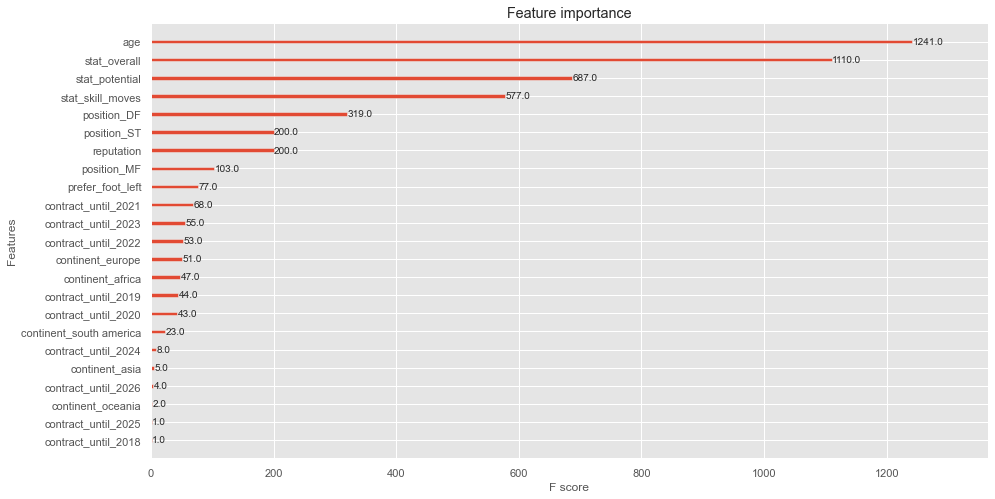

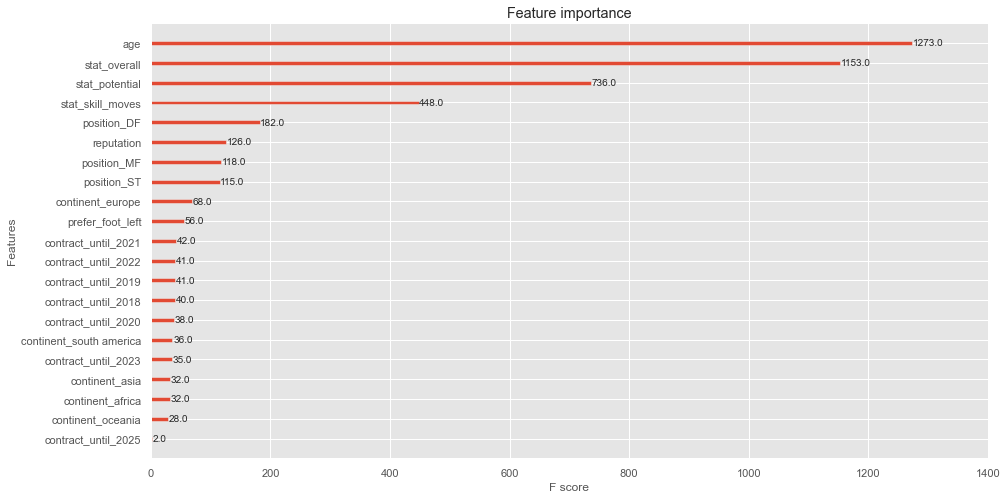

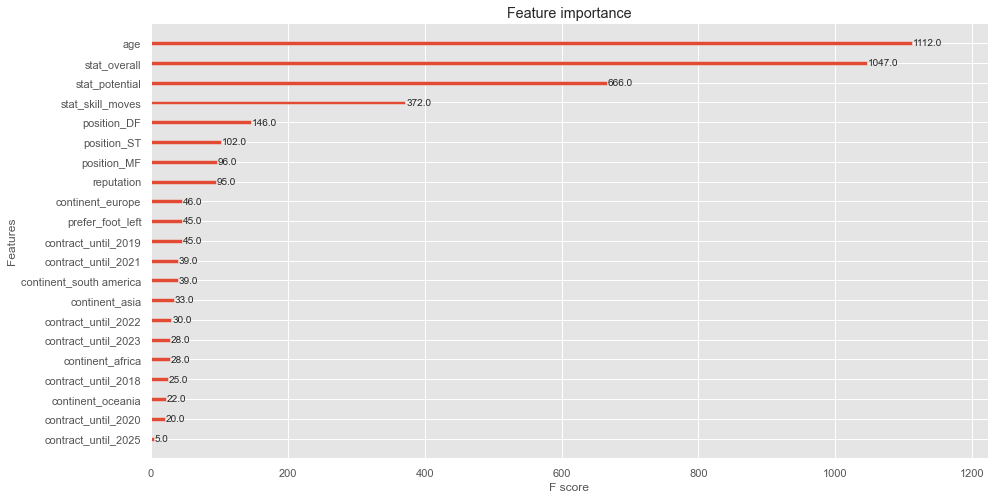

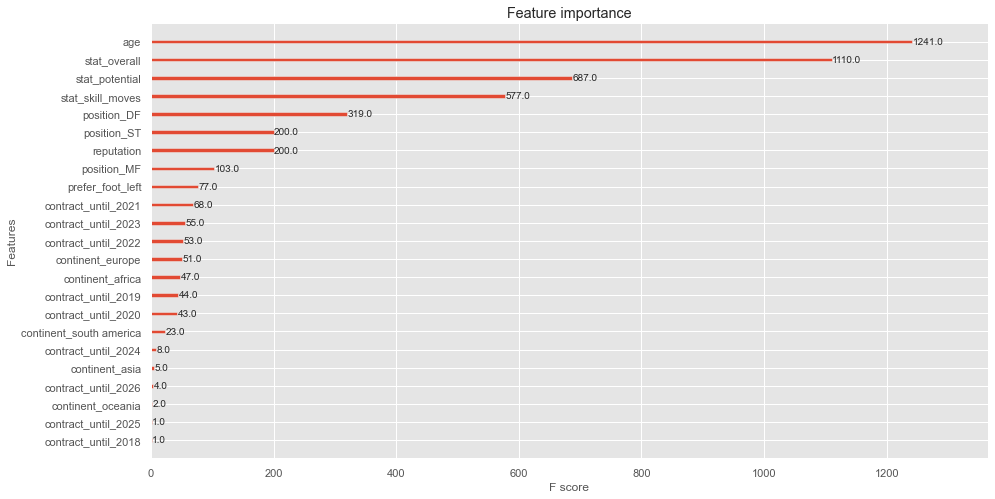

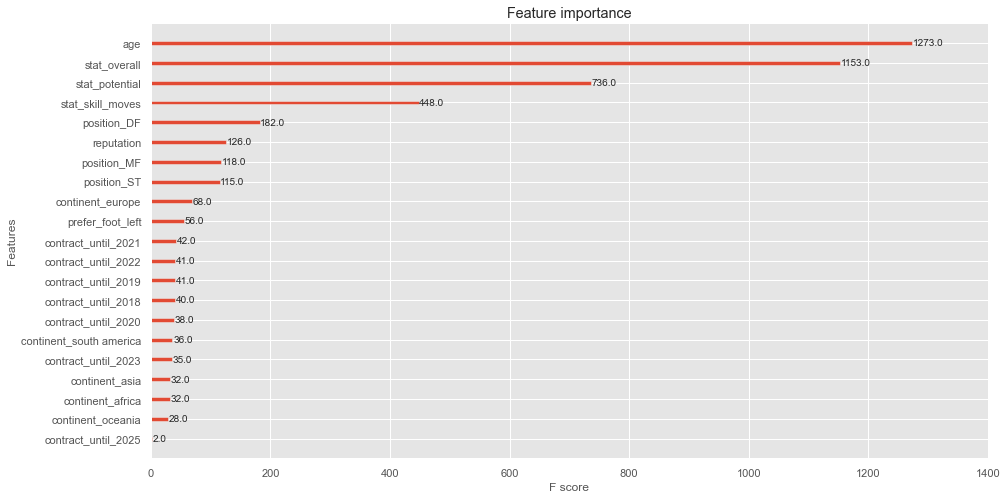

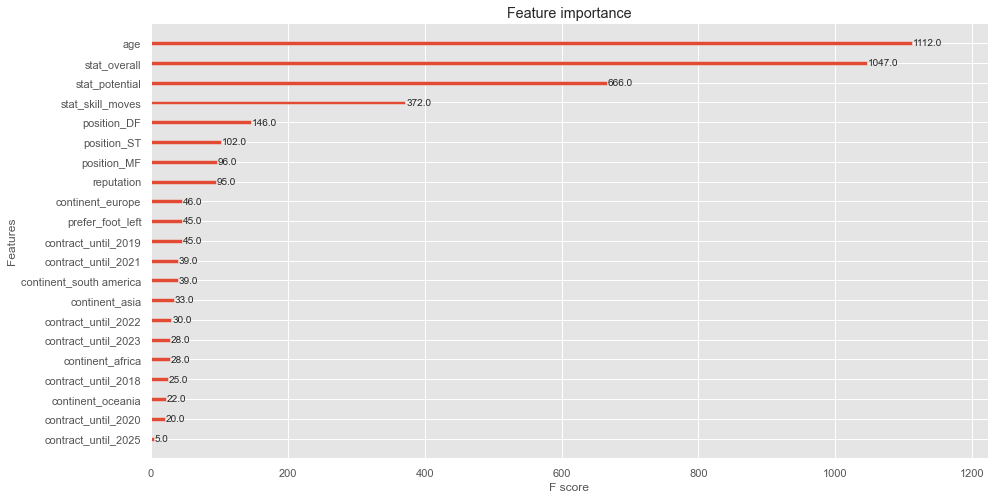

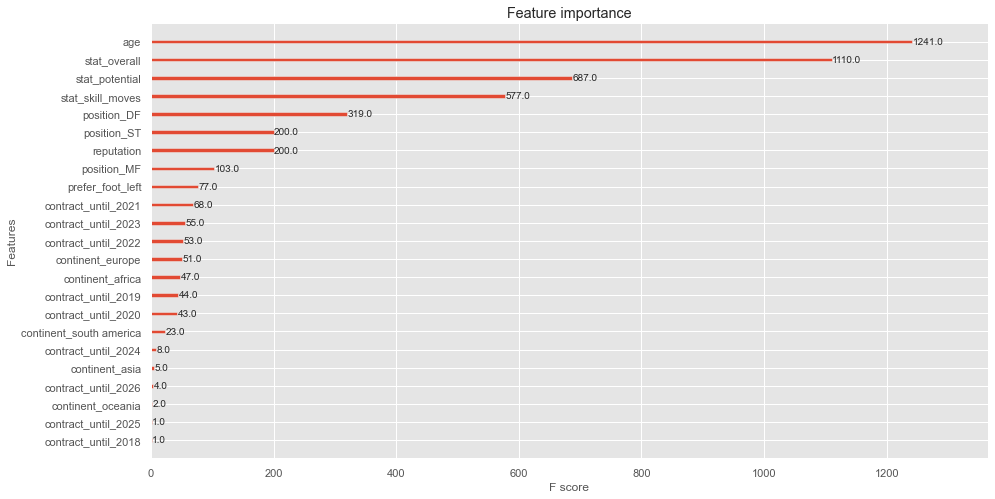

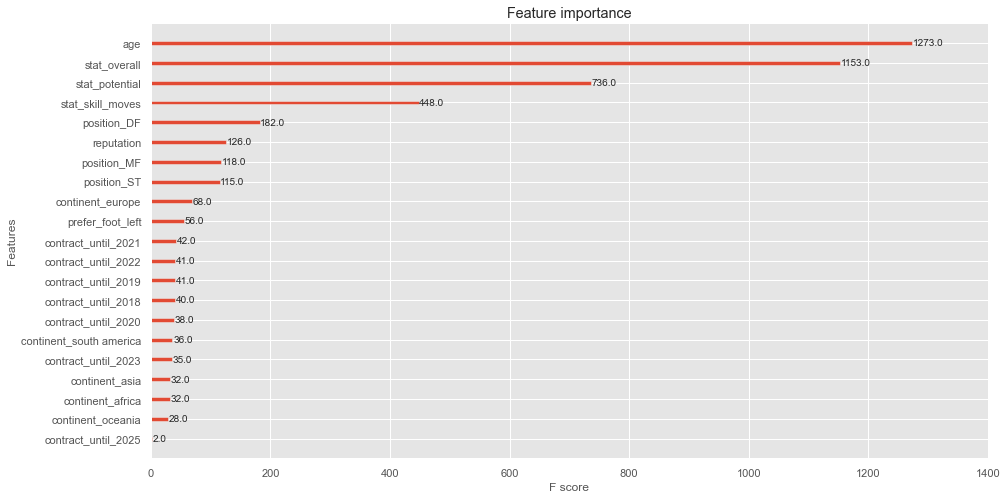

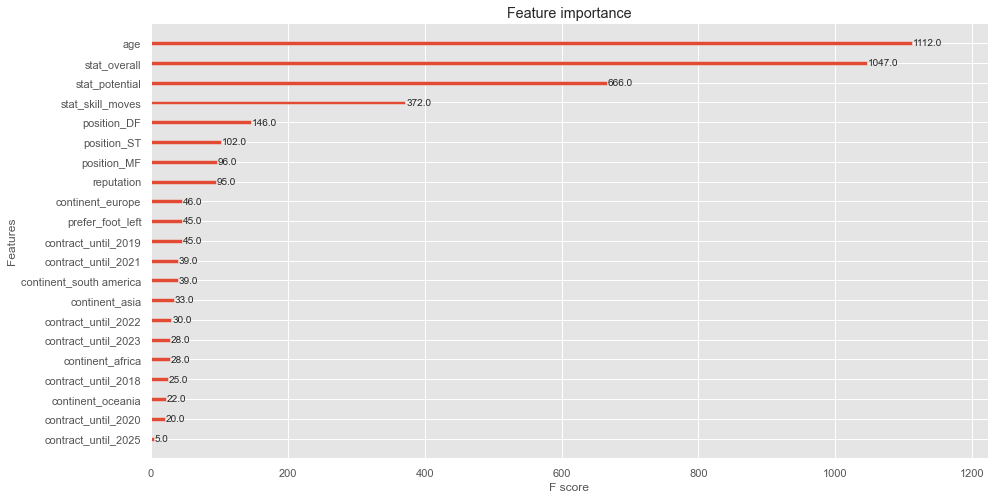

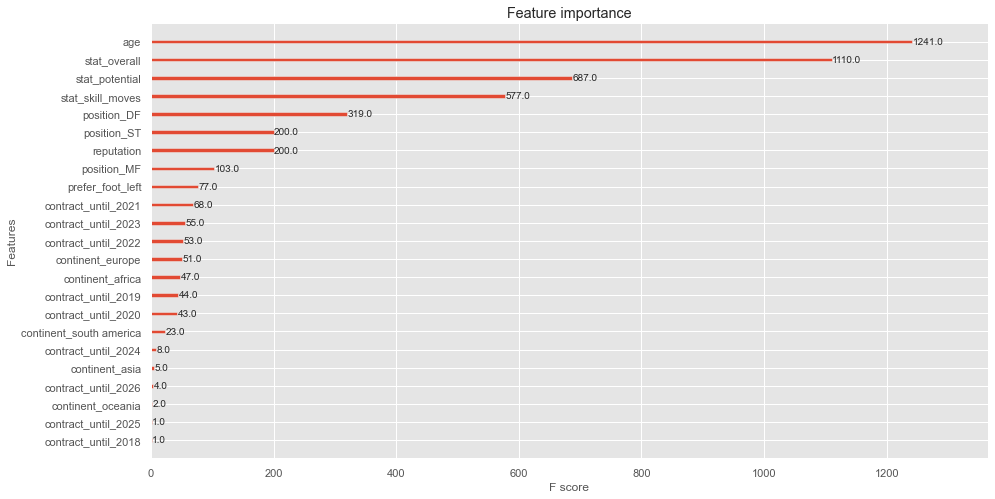

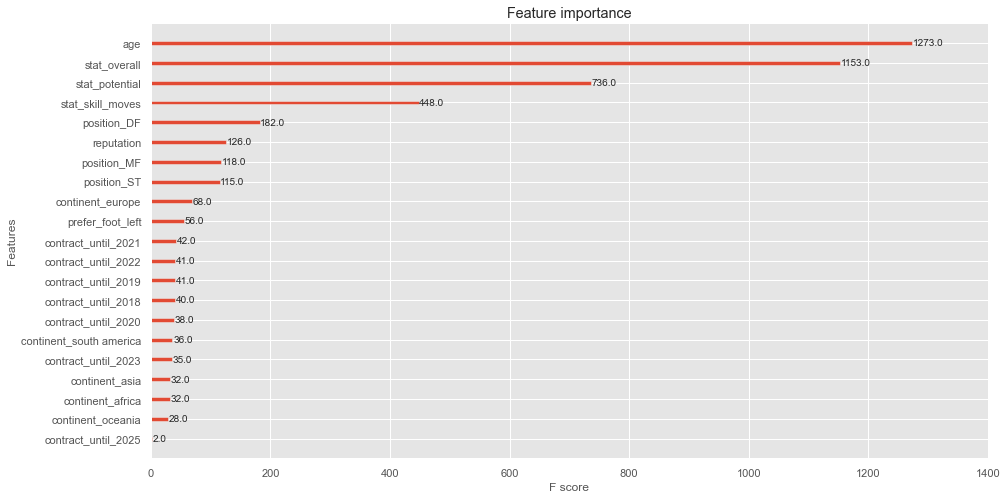

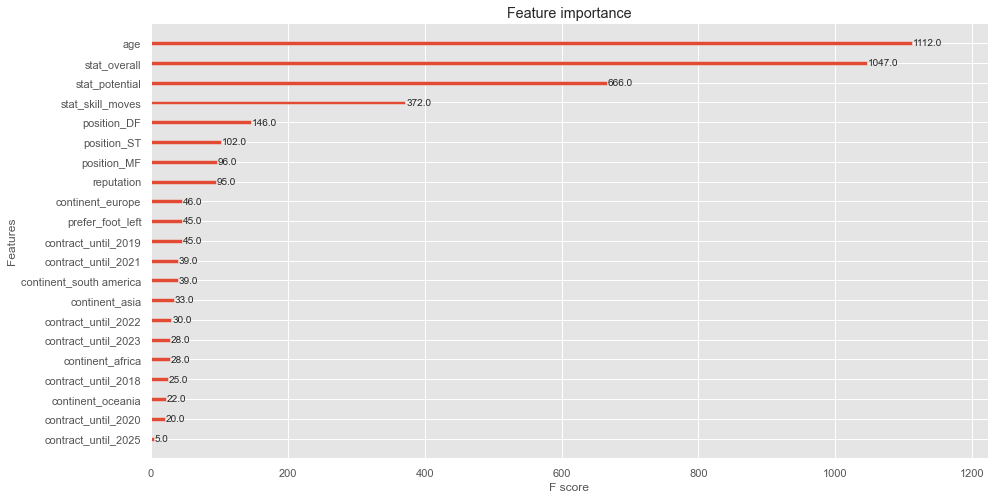

In [100]:
#데이터셋별로 모델링 진행

for i, a in enumerate(x_dataset):
    for j, b in enumerate(y_dataset):
        
        X_train, X_test, y_train, y_test = train_test_split(a, b, test_size=0.3, random_state=9)
        
        xgb = xgboost.XGBRegressor(n_estimators=100,
                                   learning_rate=0.08,
                                   gamma=0,
                                   subsample=0.75,
                                   colsample_bytree=1,
                                   max_depth=7)
        xgb.fit(X_train, y_train)

        pred_tr = xgb.predict(X_train)
        pred_test = xgb.predict(X_test)
        rmse_tr = (np.sqrt(mean_squared_error(y_train, pred_tr)))
        rmse_test = (np.sqrt(mean_squared_error(y_test, pred_test)))

        x_name.append(x_dataset_name[i])
        y_name.append(y_dataset_name[j])
        tr_rmse.append(rmse_tr)
        test_rmse.append(rmse_test)
        train_score.append(xgb.score(X_train,y_train))
        test_score.append(xgb.score(X_test, y_test))
        print(x_dataset_name[i], y_dataset_name[j], xgboost.plot_importance(xgb)) #변수 중요도

- 전반적으로 age > stat_overall > stat_potential 순으로 중요한 것으로 나타남.

In [101]:
#결과를 데이터 프레임으로 정리
df_xgboost = pd.DataFrame({'X_data' : x_name,
                  'y_data' : y_name,
                  'train_rmse' : tr_rmse,
                  'test_rmse' : test_rmse,
                  'train_score' : train_score,
                  'test_score' : test_score})

In [102]:
#모든 테이블에 알고리즘 추가
df_linear['algorithm']="linear regression"
df_randomforest['algorithm']="randomforest"
df_xgboost['algorithm']="xgboost"

In [103]:
#모든 분석을 한 테이블로 합치기
result = pd.concat([df_linear, df_randomforest, df_xgboost], ignore_index=True)

- 알고리즘의 경우, xgboost>random forest>linear regression 순으로 의 결과가 좋은 것으로 나타남.
- xgboost와 random forest 경우, X 변수의 스케일링 여부와 무관하게 결과가 나타남.
- xgboost와 ramdom forest의 y변수의 경우엔 미세하지만 log변환이 boxcox보다 결과가 좋은 것으로 나타남.
- linear regression의 경우, y변수 왜도에 대한 영향을 매우 많이 받는 것으로 나타남.

In [104]:
#test score 기준 내림차순
result.sort_values(by=['test_score'], ascending=False)

,X_data,y_data,train_rmse,test_rmse,train_score,test_score,algorithm
34,x_data_std,y_data_log,0.0558,0.0744,0.9984,0.9971,xgboost
25,x_data_basic,y_data_log,0.0558,0.0744,0.9984,0.9971,xgboost
28,x_data_log,y_data_log,0.0558,0.0744,0.9984,0.9971,xgboost
31,x_data_minmax,y_data_log,0.0558,0.0744,0.9984,0.9971,xgboost
35,x_data_std,y_data_boxcox,0.0190,0.0247,0.9982,0.9969,xgboost
29,x_data_log,y_data_boxcox,0.0190,0.0247,0.9982,0.9969,xgboost
26,x_data_basic,y_data_boxcox,0.0190,0.0247,0.9982,0.9969,xgboost
32,x_data_minmax,y_data_boxcox,0.0190,0.0247,0.9982,0.9969,xgboost
16,x_data_log,y_data_log,0.0373,0.0934,0.9993,0.9955,randomforest
22,x_data_std,y_data_log,0.0365,0.0936,0.9993,0.9955,randomforest


- 이 중 가장 높은 test score를 나타내는 모델로 데이콘에 제출한 결과, 점수는 1,225,044점으로 나타남.
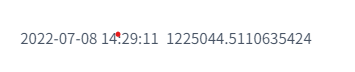

# xgboost tuning

In [105]:
x_name = []
y_name = []
tr_rmse = []
test_rmse = []
train_score=[]
test_score = []
c_name=[]
d_name=[]
e_name=[]

### Boost Parameter
- Learning rate(일반적으로 0.01 - 0.2)
- max_depth: Tree 깊이 수
- gamma: split 하기 위한 최소의 loss 감소 정의
- subsample: 데이터 중 샘플링(0.5 - 1)
- colsample_bytree: column 중 sampling(0.5 - 1)


In [106]:
esti = [100, 300, 500, 700, 900]
lr = [0.01, 0.03, 0.05, 0.07, 0.09, 0.12, 0.15, 0.18, 0.2]
m_th = [2,3,4,5,6,7]
sub_samp=[0.5, 0.6, 0.7, 0.8]
cols_by=[0.5, 0.7, 0.9]

for a in esti:
    for b in lr:
        for c in m_th:
            for d in sub_samp:
                for e in cols_by:

                    X_train, X_test, y_train, y_test = train_test_split(x_data_basic, 
                                                                        y_data_log, 
                                                                        test_size=0.3, 
                                                                        random_state=9)

                    xgb = xgboost.XGBRegressor(n_estimators=a,
                                               learning_rate=b,
                                               gamma=0,
                                               subsample=d,
                                               colsample_bytree=e,
                                               max_depth=c)
                    xgb.fit(X_train, y_train)

                    pred_tr = xgb.predict(X_train)
                    pred_test = xgb.predict(X_test)
                    rmse_tr = (np.sqrt(mean_squared_error(y_train, pred_tr)))
                    rmse_test = (np.sqrt(mean_squared_error(y_test, pred_test)))

                    x_name.append(a)
                    y_name.append(b)
                    c_name.append(c)
                    d_name.append(d)
                    e_name.append(e)
                    tr_rmse.append(rmse_tr)
                    test_rmse.append(rmse_test)
                    train_score.append(xgb.score(X_train,y_train))
                    test_score.append(xgb.score(X_test, y_test))

In [107]:
df_xgboost = pd.DataFrame({'estimator' : x_name,
                  'learningrate' : y_name,
                  'max_depth' : c_name,
                  'sub_sample' : d_name,
                  'colsample_bytree' : e_name,
                  'train_rmse' : tr_rmse,
                  'test_rmse' : test_rmse,
                  'train_score' : train_score,
                  'test_score' : test_score})

- train score를 내림차순으로 살펴보면 parameter들이 높은 값들이다.
- 무조건 높은 parameter를 찾기보다 적정한 parameter를 찾는 것이 좋은 모델링이다.

- test score를 기준으로 내림차순하여 살펴보면, max_depth=3과 learning rate=0.03이 눈에 띈다. 

- 찾은 parameter 모델로 제출한 모델의 점수는 909,143점으로 전의 모델보다 점수가 줄어든 것을 알 수 있다.
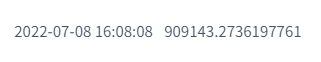

In [110]:
df_xgboost.sort_values(by=['train_score','test_score'], ascending=False).head(5)

,estimator,learningrate,max_depth,sub_sample,colsample_bytree,train_rmse,test_rmse,train_score,test_score
3239,900,0.2000,7,0.8000,0.9000,0.0134,0.0827,0.9999,0.9965
3167,900,0.1800,7,0.8000,0.9000,0.0139,0.0779,0.9999,0.9969
3236,900,0.2000,7,0.7000,0.9000,0.0140,0.0807,0.9999,0.9966
3164,900,0.1800,7,0.7000,0.9000,0.0143,0.0792,0.9999,0.9968
2591,700,0.2000,7,0.8000,0.9000,0.0145,0.0823,0.9999,0.9965


In [111]:
df_xgboost.sort_values(by=['test_score'], ascending=False).head(5)

,estimator,learningrate,max_depth,sub_sample,colsample_bytree,train_rmse,test_rmse,train_score,test_score
3110,900,0.1800,3,0.5000,0.9000,0.0514,0.0647,0.9987,0.9978
2714,900,0.0300,6,0.5000,0.9000,0.0419,0.0650,0.9991,0.9978
3116,900,0.1800,3,0.7000,0.9000,0.0499,0.0652,0.9987,0.9978
2066,700,0.0300,6,0.5000,0.9000,0.0459,0.0654,0.9989,0.9978
2702,900,0.0300,5,0.5000,0.9000,0.0489,0.0655,0.9988,0.9978


In [121]:
print('a')

a


In [122]:
test_data = pd.read_csv("FIFA_test.csv")
test_data

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,1,Cristiano Ronaldo,33,europe,2022,ST,right,5.0000,94,94,5.0000
1,2,Neymar Jr,26,south america,2022,ST,right,5.0000,92,93,5.0000
2,4,K. De Bruyne,27,europe,2023,MF,right,4.0000,91,92,4.0000
3,5,E. Hazard,27,europe,2020,ST,right,4.0000,91,91,4.0000
4,6,L. Modrić,32,europe,2020,MF,right,4.0000,91,91,4.0000
...,...,...,...,...,...,...,...,...,...,...,...
3823,16924,R. Takae,20,asia,2021,MF,right,1.0000,48,63,2.0000
3824,16929,L. Wahlstedt,18,europe,2018,GK,right,1.0000,48,65,1.0000
3825,16932,Y. Góez,18,south america,2021,MF,right,1.0000,48,65,2.0000
3826,16937,A. Kaltner,18,europe,2020,ST,right,1.0000,47,61,2.0000
